In [ ]:
!pip install librosa

In [ ]:
import scipy.io.wavfile as scp
import numpy as np
import pandas as pd
import math
import pyperclip
import librosa
import librosa.display
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate


In [ ]:
def lowest_power_of_2(x):
    power = math.floor(math.log2(x))
    lower_power = 2 ** power
    return lower_power

def reverse_string(input_string):
    return input_string[::-1]

In [ ]:
# Function for Gaussian smoothing
def apply_gaussian_smoothing(ori_value, new_value, amplitude, sigma=1.0):
    """Applies Gaussian smoothing based on the difference in amplitude."""
    if amplitude == 0:
        return ori_value  # No change if there's no difference in amplitude
    gaussian_kernel = np.exp(-0.5 * (amplitude ** 2) / (sigma ** 2))
    smoothed_value = (1 - gaussian_kernel) * ori_value + gaussian_kernel * new_value
    return round(smoothed_value)

In [ ]:
# Function to perform polynomial smoothing (cubic smoothing)
def polynomial_smoothing(samples, degree=3):
    smoothed_samples = []
    for i in range(1, len(samples) - 1):
        # Take the previous, current, and next samples for smoothing
        x = np.array([i-1, i, i+1])
        y = np.array([samples[i-1], samples[i], samples[i+1]])
        # Fit a polynomial of the given degree (e.g., cubic)
        coefficients = np.polyfit(x, y, degree)
        poly = np.poly1d(coefficients)
        smoothed_samples.append(poly(i))
    return smoothed_samples


In [ ]:
process_index = 200

In [ ]:
process_index += 1
process_index

202

# Embedding
## Step 1 - Read audio and sample to 16-bit and normalize audio sample

In [ ]:
payFilename = '/content/Payload/payload1.txt'
wavFilename = '/content/Audio/data1_mono.wav'

samplerate, audiodata = scp.read(wavFilename)
print("\nEmbedding Process~~~\n")
print("Length of Audio Sample: ", len(audiodata))
normaudiodata = [x + 32768 for x in audiodata]


Embedding Process~~~

Length of Audio Sample:  132299


## Step 2 - Make interpolation sample between each original sample

In [ ]:
interpolasi = np.resize(normaudiodata, ((len(normaudiodata)*2)-1))
x = 0
for i in range(len(interpolasi)):
    # Even Sample (Original Sample)
    if i % 2 == 0:
        interpolasi[i] = normaudiodata[int(i/2)]
    # Odd Sample (Interpolation)
    else:
        interpolasi[i] = math.floor((normaudiodata[int((i-1)/2)] + normaudiodata[i - x]) / 2)
        x += 1
eInter = interpolasi.copy()

# Save Interpolation Audio
interpolasi = [x - 32768 for x in interpolasi]
scp.write(f'/content/Output/{process_index}-InterAudio-embed.wav', samplerate, np.array(interpolasi, dtype=np.int16))

## Step 3 - Find variable C

In [ ]:
# Distance between the interpolated samples and the normalized original samples
duration = len(interpolasi) / samplerate
C = (duration * 1000)/((len(interpolasi))*2)
print("C = ", C)

C =  0.011337868480725625


## Steps 4 and 5 - Embedding Process


In [ ]:
median_amplitude = np.median(interpolasi)
amplitude_variance = np.var(interpolasi)
threshold = median_amplitude + 0.5 * amplitude_variance
max_layering = 16

In [ ]:
def modify_lsb(sample, payload_bit):
    lsb_mask = 0b1
    modified_sample = (sample & ~lsb_mask) | (payload_bit & lsb_mask)
    return modified_sample


In [ ]:
# def modify_dsss(interpolation_sample, payload_bit, pn_bit):
#     if payload_bit == 1:
#         return interpolation_sample + pn_bit
#     else:
#         return interpolation_sample - pn_bit

In [ ]:
# amp = 0.1
# delay_short = 100
# delay_long = 200

# # Fungsi untuk menambahkan echo
# def add_echo(signal, delay, amp):
#     echo = np.zeros_like(signal)
#     echo[delay:] = amp * signal[:-delay]
#     return signal + echo

In [ ]:
# def modify_parity(value, payload_bit):
#     """
#     Modify the parity of the given value to match the payload_bit.
#     - value: integer representing the audio sample.
#     - payload_bit: 0 or 1, the bit to embed.
#     """
#     parity = bin(value).count('1') % 2  # Calculate parity (0 if even, 1 if odd)
#     if parity != payload_bit:
#         if value % 2 == 0:
#             value += 1
#         else:  # If value is odd, make it even
#             value -= 1
#     return value

In [ ]:
with open(payFilename, 'r') as file:
    payload = file.read()
payload = payload.replace('\t', '')
print("Length of Payload : ", len(payload))
nSpace = 0
interpolasi = eInter.copy()
truekey = ''
beforeSmoothI = interpolasi.copy()
afterSmoothI = interpolasi.copy()
for i in range(len(interpolasi)-1):
    # Step 5 - Odd number (Interpolation)
    if i % 2 != 0:
        key = ''
        if abs(lowN) == 0:
            key += '00'
        oriInterpolasi = interpolasi[i]
        for x in range(abs(lowN)):
            if len(pn) < abs(lowN) and x == len(pn):  # no payload anymore
                break
            payload_bit = int(pn[x])

            interpolasi[i] = modify_lsb(interpolasi[i], payload_bit)

            if payload_bit > 0:
                key += '11'
            elif payload_bit == 0:
                key += '10'
        beforeSmoothI[i] = interpolasi[i]
        afterSmoothI[i] = math.ceil((oriInterpolasi+interpolasi[i])/2)
        interpolasi[i] = math.ceil((oriInterpolasi+interpolasi[i])/2)

        # Bound checking if the interpolasi [i] exceeds 16 bit format
        if interpolasi[i] < 0 or interpolasi[i] > 65535:
            interpolasi[i] = oriInterpolasi
            afterSmoothI[i] = oriInterpolasi
            key = '01'
            nSpace-=abs(lowN)
        reversed_key = reverse_string(key)
        truekey += reversed_key
        if nSpace > len(payload) or nSpace == len(payload): # no payload anymore
            break

    # Step 4 - Even number except last (Original)
    elif i < len(interpolasi):
        d = math.sqrt((i+1-(i+2))**2+(interpolasi[i]-interpolasi[i+1])**2) # length (d) between the original and interpolated samples
        N = math.floor(math.log2(C * d))
        if N != 0:
            lowN = lowest_power_of_2(abs(N))
            # Adaptive threshold
            if interpolasi[i] > threshold:
                lowN = max(lowN // 2, 1)
            else:
                lowN = min(lowN * 2, max_layering)
        else:
            lowN = 0

        if len(payload[nSpace:len(payload)]) < lowN: # if the remaining length of the payload is less than lowN
            lowN = lowest_power_of_2(len(payload[nSpace:len(payload)]))

        if lowN == 0:
            lowN = 0
            pn = 0
            nSpace+=abs(lowN)
        elif nSpace < len(payload) and (nSpace + abs(lowN) - 1) < len(payload): # does not exceed the lenght of the payload
            pn = payload[nSpace:(nSpace+abs(lowN))]
            nSpace+=abs(lowN)
        elif nSpace + abs(lowN) > len(payload): # exceed the lenght of the payload
            pn = payload[nSpace:len(payload)]
            nSpace+=abs(lowN)
print("Length of Key : ", len(truekey))
err = 0
for i in range(len(afterSmoothI)):
    if afterSmoothI[i] != beforeSmoothI[i]:
        err+=1
print("How many sample difference (before & after smoothing) = ", err)

Length of Payload :  1000
Length of Key :  2228
How many sample difference (before & after smoothing) =  97


## Step 6 - Denormalize and save Stego Audio sample


In [ ]:
interpolasi = [x - 32768 for x in interpolasi]
scp.write(f'/content/Output/{process_index}-StegoAudio-embed.wav', samplerate, np.array(interpolasi, dtype=np.int16))

## Embedding Results

In [ ]:
## Find PSNR value
isamplerate, iaudiodata = scp.read(f'/content/Output/{process_index}-InterAudio-embed.wav')
fsamplerate, faudiodata = scp.read(f'/content/Output/{process_index}-StegoAudio-embed.wav')

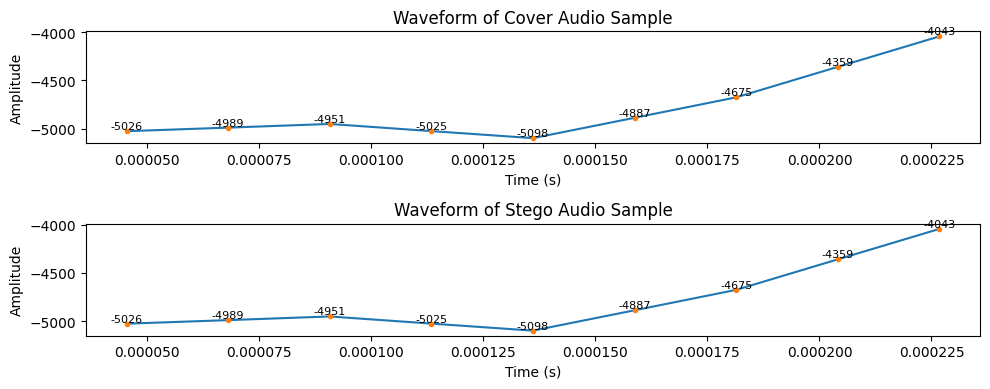

In [ ]:
## Show Waveform
start_sample = 2
end_sample = 10
iad = iaudiodata[start_sample:end_sample+1]
time1 = (1/isamplerate) * np.arange(start_sample, end_sample+1)
fad = faudiodata[start_sample:end_sample+1]
time2 = (1/fsamplerate) * np.arange(start_sample, end_sample+1)

plt.figure(figsize=(10, 4))

plt.subplot(2, 1, 1)
plt.plot(time1, iad)
plt.plot(time1, iad, '.', markersize=6)
for i, value in zip(time1, iad):
    plt.text(i, value, f'{value}', fontsize=8, ha='center', va='bottom')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform of Cover Audio Sample")

plt.subplot(2, 1, 2)
plt.plot(time1, fad)
plt.plot(time2, fad, '.', markersize=6)
for i, value in zip(time2, fad):
    plt.text(i, value, f'{value}', fontsize=8, ha='center', va='bottom')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform of Stego Audio Sample")

plt.tight_layout()
plt.show()

In [ ]:
# Ensure both signals have the same length
min_length = min(len(iaudiodata), len(faudiodata))
original_audio = iaudiodata[:min_length]
reconstructed_audio = faudiodata[:min_length]

In [ ]:
# Calculate the Mean Squared Error (MSE)
tes = (original_audio - reconstructed_audio)
mse = np.mean(tes ** 2)

# Determine the maximum possible value for the audio signal
max_possible_value = 2 ** 16

# Calculate the PSNR value
psnr_value = 10 * np.log10((max_possible_value ** 2) / mse)

# pyperclip.copy(psnr_value)
print('PSNR value : ', psnr_value)

PSNR value :  131.86313057366272


# Extracting Process
## Step 1 - Normalize stego audio


In [ ]:
print("\nExtracting Process~~~\n")
normstegodata = [x + 32768 for x in faudiodata]


Extracting Process~~~



## Step 2-1 - Divide sample between odd (changed) and even (non-changed) samples

In [ ]:
oriSample = np.resize(normstegodata, (int((len(normstegodata)+1)/2)))
paySample = np.resize(normstegodata, (int(len(normstegodata)-((len(normstegodata)+1)/2))))
for i in range(len(normstegodata)):
    # Even samples (original)
    if i % 2 == 0:
        oriSample[int(i/2)] = normstegodata[i]
    # Odd samples (payload-embedded samples)
    else:
        paySample[int((i-1)/2)] = normstegodata[i]
oriSample = [x + 0 for x in oriSample]
paySample = [x + 0 for x in paySample]

## Step 2-2 - Make another sample using interpolation from the divided even samples

In [ ]:
stegoInterpolasi = np.resize(oriSample, ((len(oriSample)*2)-1))
x = 0
for i in range(len(stegoInterpolasi)):
    if i % 2 == 0:
        stegoInterpolasi[i] = oriSample[int(i/2)]
    else:
        stegoInterpolasi[i] = math.floor((oriSample[int((i-1)/2)]+oriSample[i-x])/2)
        x+=1

## Step 3-1 - Save the interpolation sample and find variable C


In [ ]:
# Distance between the interpolated samples and the normalized original samples
stegoInterpolasi = [x - 32768 for x in stegoInterpolasi]
scp.write(f'/content/Output/{process_index}-InterAudio-extract.wav', samplerate, np.array(stegoInterpolasi, dtype=np.int16))
stegoDuration = len(stegoInterpolasi) / samplerate
sC = (stegoDuration * 1000)/((len(stegoInterpolasi))*2)
print("C = ", sC)

C =  0.011337868480725625


## Steps 3-2 and 4 - Extraction Process


In [ ]:
# Step 4 - Odd sample (changed sample)
stegoInterpolasi = [x + 32768 for x in stegoInterpolasi]
spay = ''
sAfterSmoothI = normstegodata.copy()
xInter = stegoInterpolasi.copy()
afterdeSmoothI = stegoInterpolasi.copy()
err = 0

for z in range(len(stegoInterpolasi)-1):
    if z % 2 != 0:  # Step 4 - Odd sample (changed sample)
        # Desmooth
        if abs(sLowN) == 1 and normstegodata[z] % 2 == stegoInterpolasi[z] % 2:
            stegoInterpolasi[z] -= 1
            afterdeSmoothI[z] = stegoInterpolasi[z]
        elif abs(sLowN) == 1 and normstegodata[z] % 2 != stegoInterpolasi[z] % 2:
            stegoInterpolasi[z] += 1
            afterdeSmoothI[z] = stegoInterpolasi[z]
        elif len(truekey) == 2 and normstegodata[z] % 2 == stegoInterpolasi[z] % 2:
            stegoInterpolasi[z] -= 1
            afterdeSmoothI[z] = stegoInterpolasi[z]
        elif len(truekey) == 2 and normstegodata[z] % 2 != stegoInterpolasi[z] % 2:
            stegoInterpolasi[z] += 1
            afterdeSmoothI[z] = stegoInterpolasi[z]
        else:
            stegoInterpolasi[z] = (normstegodata[z]*2) - stegoInterpolasi[z]
            afterdeSmoothI[z] = stegoInterpolasi[z]

        retpay = ''
        if abs(sLowN) == 0 and truekey[:2] == '00':
            retpay += ''
            truekey = truekey[2:]
        elif truekey[:2] == '10':
            retpay += ''
            truekey = truekey[2:]
        else:
            for x in range(abs(sLowN)):
                if len(truekey) == 0:
                    break
                elif truekey[:2] == '01':
                    retpay += '0'
                    truekey = truekey[2:]
                    stegoInterpolasi[z] += 1  # Increment the LSB (LSB extraction)
                elif truekey[:2] == '11':
                    retpay += '1'
                    truekey = truekey[2:]
                    stegoInterpolasi[z] -= 1  # Decrement the LSB (LSB extraction)

        reversed_pay = reverse_string(retpay)
        spay += reversed_pay

        if len(truekey) == 0:
            break

    # Step 3-2 - Even sample except last (Original)
    elif z < len(stegoInterpolasi):
        sd = math.sqrt((z+1-(z+2))**2 + (stegoInterpolasi[z]-stegoInterpolasi[z+1])**2)
        sN = math.floor(math.log2(sC * sd))
        if sN != 0:
            sLowN = lowest_power_of_2(abs(sN))
            if stegoInterpolasi[z] > threshold:
                sLowN = max(sLowN // 2, 1)
            else:
                sLowN = min(sLowN * 2, max_layering)
        else:
            sLowN = 0
        if len(truekey)/2 < sLowN:
            sLowN = lowest_power_of_2(len(truekey)/2)



## Step 5 - Ensure that the payload retrived and the original payload are the same


In [ ]:
sPayload = "".join(str(x) for x in spay)
print("Length of Retrieved Payload = ", len(sPayload))
print("Length of Original Payload  = ", len(payload))
rpayload = sPayload[:1] + sPayload[1:len(payload)].replace('', '\t')
truepayload = payload[:1] + payload[1:].replace('', '\t')
pc = ",".join(str(x) for x in payload)

oriSample = [x - 32768 for x in oriSample]
err = 0
for i in range(len(oriSample)):
    if oriSample[i] != audiodata[i]:
        err+=1
print("How many error sample (original cover & retrieved sample from stego) = ", err)
err = 0
for i in range(len(sPayload)):
    if sPayload[i] != payload[i]:
        err+=1
print("How many error payload = ", err)


Length of Retrieved Payload =  1000
Length of Original Payload  =  1000
How many error sample (original cover & retrieved sample from stego) =  0
How many error payload =  0


# Step 6 - Save Payload


In [ ]:
with open(f'/content/Output/{process_index}-RetrievedPayload.txt', 'w') as file:
    file.write(rpayload)
if sPayload[:len(payload)] == payload:
    print("Payload retrieved successfully.")
else:
    # print("Fail to get the payload.")
    raise ValueError("Fail to get the payload.")

Payload retrieved successfully.


## Step 7 - Denormalize and save Original Audio sample

In [ ]:
scp.write(f'/content/Output/{process_index}-OriginalAudio-extract.wav', samplerate, np.array(oriSample, dtype=np.int16))
ocsamplerate, ocaudiodata = scp.read(f'/content/Output/{process_index}-OriginalAudio-extract.wav')
if np.array_equal(ocaudiodata, audiodata):
    print("Cover retrieved successfully.")
else:
    print("Cover is not the same as the original.")

Cover retrieved successfully.
